In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


### Load Python Pakages

In [2]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

#preprocessing

#feature engineering
from sklearn.feature_selection import mutual_info_classif


#algorithms
from xgboost import XGBClassifier
import xgboost as xgb

#model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

#!pip3 install yellowbrick
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, DiscriminationThreshold

#!pip3 install shap
import shap

random_state = 42

### Lets look into data

In [3]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv', index_col=[0])
#original_df = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv', index_col=[0])

train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [4]:
print(train_df.shape)
print(test_df.shape)

(11504798, 11)
(7669866, 10)


### Descpriptive statistics

In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Region_Code,11504798.0,26.418690,12.991590,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Response,11504798.0,0.122997,0.328434,0.0,0.0,0.0,0.0,1.0


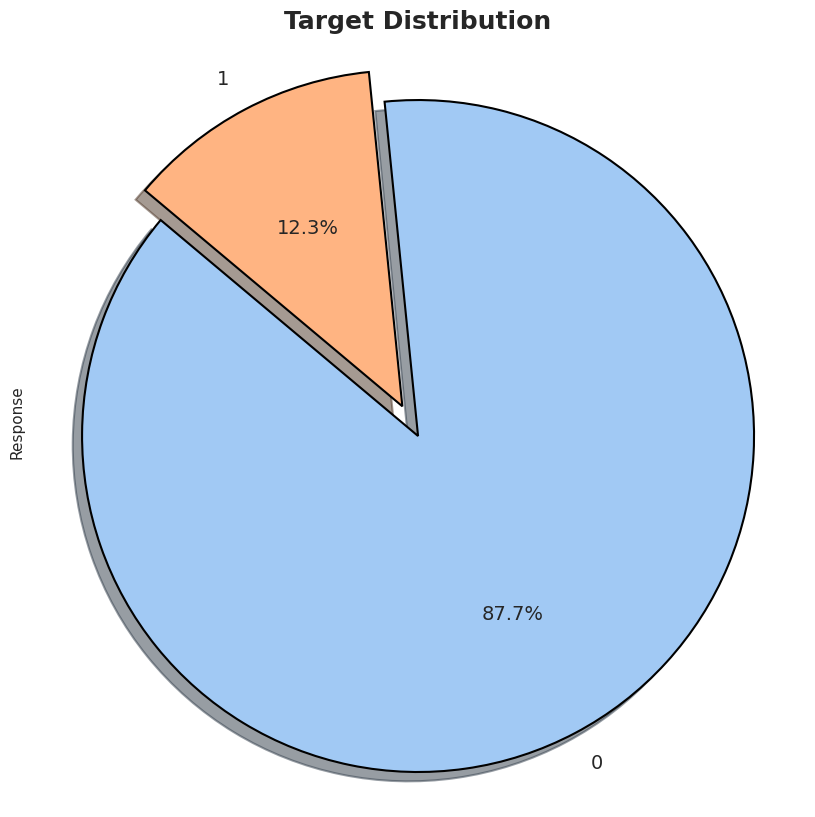

In [6]:
plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.05 for _ in range(train_df['Response'].nunique())]

# Plotting
train_df.groupby('Response')['Response'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

### Grouping features for preprocessing purposes

In [7]:
train_df.nunique().sort_values()

Gender                      2
Driving_License             2
Previously_Insured          2
Vehicle_Damage              2
Response                    2
Vehicle_Age                 3
Region_Code                54
Age                        66
Policy_Sales_Channel      152
Vintage                   290
Annual_Premium          51728
dtype: int64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


### Exploratory Data Analysis

In [9]:
#Data is huge just take some sample for eda
eda_df = train_df
#.sample(frac=0.5)
sub_df = test_df
#.sample(frac=0.5)

In [10]:
print(eda_df.shape)
print(sub_df.shape)

(11504798, 11)
(7669866, 10)


In [11]:
eda_df.describe().T
sub_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,7669866.0,38.391369,14.999507,20.0,24.0,36.0,49.0,85.0
Driving_License,7669866.0,0.998021,0.044444,0.0,1.0,1.0,1.0,1.0
Region_Code,7669866.0,26.426614,12.994326,0.0,15.0,28.0,35.0,52.0
Previously_Insured,7669866.0,0.463077,0.498635,0.0,0.0,0.0,1.0,1.0
Annual_Premium,7669866.0,30465.525668,16445.864722,2630.0,25280.0,31827.0,39460.0,540165.0
Policy_Sales_Channel,7669866.0,112.364992,54.073585,1.0,29.0,151.0,152.0,163.0
Vintage,7669866.0,163.899577,79.984449,10.0,99.0,166.0,232.0,299.0


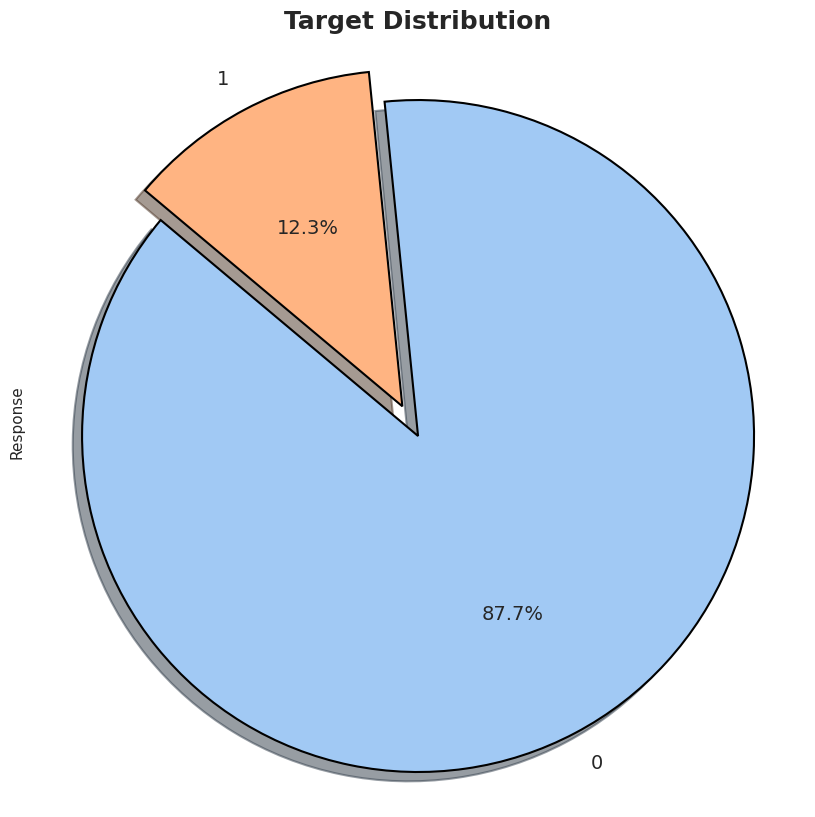

In [12]:
#Target frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.05 for _ in range(eda_df['Response'].nunique())]

# Plotting
eda_df.groupby('Response')['Response'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

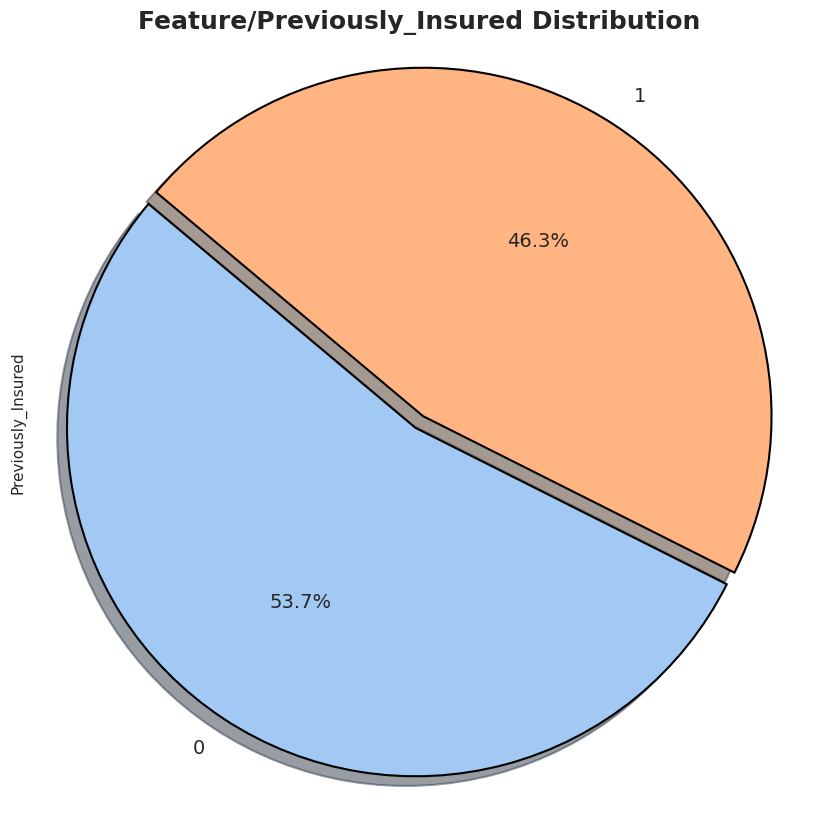

In [13]:
#Feature frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.02 for _ in range(eda_df['Previously_Insured'].nunique())]

# Plotting
eda_df.groupby('Previously_Insured')['Previously_Insured'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Feature/Previously_Insured Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

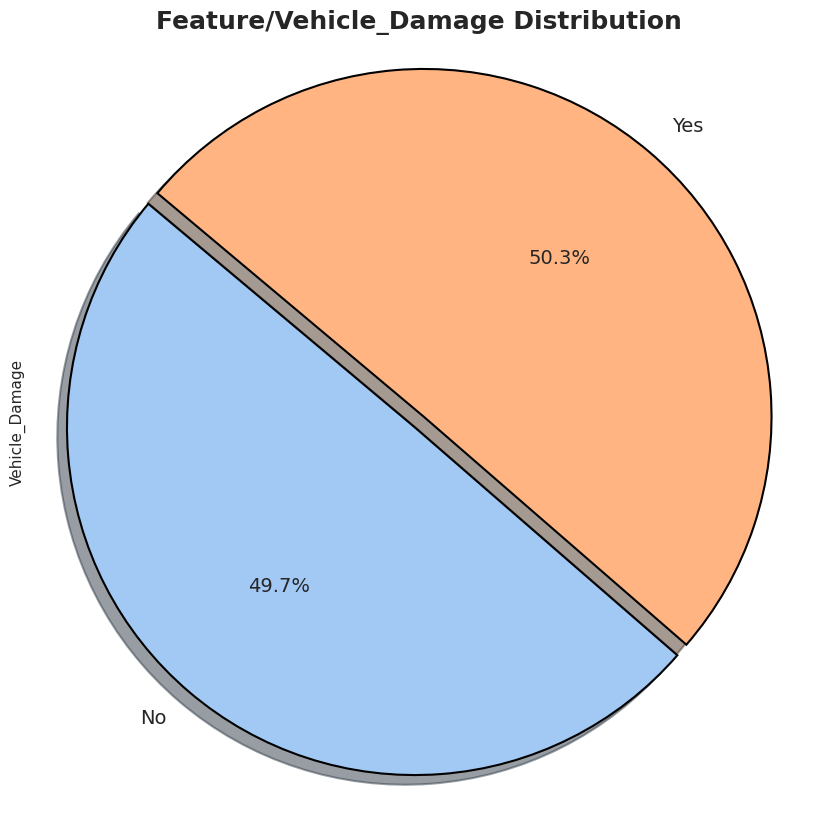

In [14]:
#Feature frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.02 for _ in range(eda_df['Vehicle_Damage'].nunique())]

# Plotting
eda_df.groupby('Vehicle_Damage')['Vehicle_Damage'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Feature/Vehicle_Damage Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

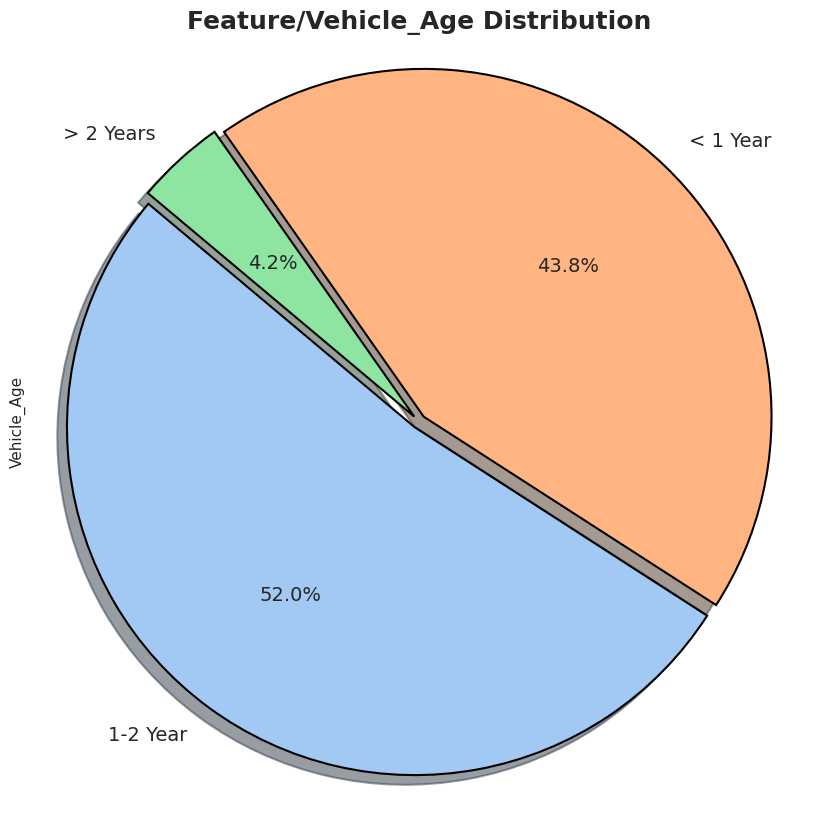

In [15]:
#Feature frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.02 for _ in range(eda_df['Vehicle_Age'].nunique())]

# Plotting
eda_df.groupby('Vehicle_Age')['Vehicle_Age'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Feature/Vehicle_Age Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

### To categorical

In [16]:
eda_df['Previously_Insured'] = eda_df['Previously_Insured'].apply(lambda x: 'Yes' if x == 1 else 'No')
eda_df.head().T

id,0,1,2,3,4
Gender,Male,Male,Female,Female,Female
Age,21,43,25,35,36
Driving_License,1,1,1,1,1
Region_Code,35.0,28.0,14.0,1.0,15.0
Previously_Insured,No,No,Yes,No,Yes
Vehicle_Age,1-2 Year,> 2 Years,< 1 Year,1-2 Year,1-2 Year
Vehicle_Damage,Yes,Yes,No,Yes,No
Annual_Premium,65101.0,58911.0,38043.0,2630.0,31951.0
Policy_Sales_Channel,124.0,26.0,152.0,156.0,152.0
Vintage,187,288,254,76,294


In [17]:
sub_df['Previously_Insured'] = sub_df['Previously_Insured'].apply(lambda x: 'Yes' if x == 1 else 'No')
sub_df.head().T

id,11504798,11504799,11504800,11504801,11504802
Gender,Female,Male,Male,Female,Male
Age,20,47,47,22,51
Driving_License,1,1,1,1,1
Region_Code,47.0,28.0,43.0,47.0,19.0
Previously_Insured,No,No,No,Yes,No
Vehicle_Age,< 1 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year
Vehicle_Damage,No,Yes,Yes,No,No
Annual_Premium,2630.0,37483.0,2630.0,24502.0,34115.0
Policy_Sales_Channel,160.0,124.0,26.0,152.0,124.0
Vintage,228,123,271,115,148


In [18]:
eda_df = pd.get_dummies(eda_df, columns=['Previously_Insured'])
eda_df['Previously_Insured_Yes'] = eda_df['Previously_Insured_Yes'].astype('int')
eda_df['Previously_Insured_No'] = eda_df['Previously_Insured_No'].astype('int')
eda_df.head().T

id,0,1,2,3,4
Gender,Male,Male,Female,Female,Female
Age,21,43,25,35,36
Driving_License,1,1,1,1,1
Region_Code,35.0,28.0,14.0,1.0,15.0
Vehicle_Age,1-2 Year,> 2 Years,< 1 Year,1-2 Year,1-2 Year
Vehicle_Damage,Yes,Yes,No,Yes,No
Annual_Premium,65101.0,58911.0,38043.0,2630.0,31951.0
Policy_Sales_Channel,124.0,26.0,152.0,156.0,152.0
Vintage,187,288,254,76,294
Response,0,1,0,0,0


In [19]:
sub_df = pd.get_dummies(sub_df, columns=['Previously_Insured'])
sub_df['Previously_Insured_Yes'] = sub_df['Previously_Insured_Yes'].astype('int')
sub_df['Previously_Insured_No'] = sub_df['Previously_Insured_No'].astype('int')
sub_df.head().T

id,11504798,11504799,11504800,11504801,11504802
Gender,Female,Male,Male,Female,Male
Age,20,47,47,22,51
Driving_License,1,1,1,1,1
Region_Code,47.0,28.0,43.0,47.0,19.0
Vehicle_Age,< 1 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year
Vehicle_Damage,No,Yes,Yes,No,No
Annual_Premium,2630.0,37483.0,2630.0,24502.0,34115.0
Policy_Sales_Channel,160.0,124.0,26.0,152.0,124.0
Vintage,228,123,271,115,148
Previously_Insured_No,1,1,1,0,1


In [20]:
eda_df = eda_df.rename(columns={'Vehicle_Age_1-2 Year': 'Vehicle_Age_1-2_Year', 'Vehicle_Age_< 1 Year': 'Vehicle_Age_less_than_1_Year',
                                'Vehicle_Age_> 2 Years': 'Vehicle_Age_greater_than_2_Years'})
eda_df.head().T

id,0,1,2,3,4
Gender,Male,Male,Female,Female,Female
Age,21,43,25,35,36
Driving_License,1,1,1,1,1
Region_Code,35.0,28.0,14.0,1.0,15.0
Vehicle_Age,1-2 Year,> 2 Years,< 1 Year,1-2 Year,1-2 Year
Vehicle_Damage,Yes,Yes,No,Yes,No
Annual_Premium,65101.0,58911.0,38043.0,2630.0,31951.0
Policy_Sales_Channel,124.0,26.0,152.0,156.0,152.0
Vintage,187,288,254,76,294
Response,0,1,0,0,0


In [21]:
sub_df = sub_df.rename(columns={'Vehicle_Age_1-2 Year': 'Vehicle_Age_1-2_Year', 'Vehicle_Age_< 1 Year': 'Vehicle_Age_less_than_1_Year',
                                'Vehicle_Age_> 2 Years': 'Vehicle_Age_greater_than_2_Years'})
sub_df.head().T

id,11504798,11504799,11504800,11504801,11504802
Gender,Female,Male,Male,Female,Male
Age,20,47,47,22,51
Driving_License,1,1,1,1,1
Region_Code,47.0,28.0,43.0,47.0,19.0
Vehicle_Age,< 1 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year
Vehicle_Damage,No,Yes,Yes,No,No
Annual_Premium,2630.0,37483.0,2630.0,24502.0,34115.0
Policy_Sales_Channel,160.0,124.0,26.0,152.0,124.0
Vintage,228,123,271,115,148
Previously_Insured_No,1,1,1,0,1


In [22]:
eda_df['Vehicle_Age'] = eda_df['Vehicle_Age'].apply(lambda x: '1-2_Year' if x == '1-2 Year' else ('less_than_1_Year' 
                                                                  if x == '< 1 Year' else ('greater_than_2_Years')))
eda_df.head().T

id,0,1,2,3,4
Gender,Male,Male,Female,Female,Female
Age,21,43,25,35,36
Driving_License,1,1,1,1,1
Region_Code,35.0,28.0,14.0,1.0,15.0
Vehicle_Age,1-2_Year,greater_than_2_Years,less_than_1_Year,1-2_Year,1-2_Year
Vehicle_Damage,Yes,Yes,No,Yes,No
Annual_Premium,65101.0,58911.0,38043.0,2630.0,31951.0
Policy_Sales_Channel,124.0,26.0,152.0,156.0,152.0
Vintage,187,288,254,76,294
Response,0,1,0,0,0


In [23]:
sub_df['Vehicle_Age'] = sub_df['Vehicle_Age'].apply(lambda x: '1-2_Year' if x == '1-2 Year' else ('less_than_1_Year' 
                                                                  if x == '< 1 Year' else ('greater_than_2_Years')))
sub_df.head().T

id,11504798,11504799,11504800,11504801,11504802
Gender,Female,Male,Male,Female,Male
Age,20,47,47,22,51
Driving_License,1,1,1,1,1
Region_Code,47.0,28.0,43.0,47.0,19.0
Vehicle_Age,less_than_1_Year,1-2_Year,1-2_Year,less_than_1_Year,1-2_Year
Vehicle_Damage,No,Yes,Yes,No,No
Annual_Premium,2630.0,37483.0,2630.0,24502.0,34115.0
Policy_Sales_Channel,160.0,124.0,26.0,152.0,124.0
Vintage,228,123,271,115,148
Previously_Insured_No,1,1,1,0,1


In [24]:
eda_df = pd.get_dummies(eda_df, columns=['Vehicle_Age'])
eda_df['Vehicle_Age_less_than_1_Year'] = eda_df['Vehicle_Age_less_than_1_Year'].astype('int')
eda_df['Vehicle_Age_1-2_Year'] = eda_df['Vehicle_Age_1-2_Year'].astype('int')
eda_df['Vehicle_Age_greater_than_2_Years'] = eda_df['Vehicle_Age_greater_than_2_Years'].astype('int')
eda_df.head().T

id,0,1,2,3,4
Gender,Male,Male,Female,Female,Female
Age,21,43,25,35,36
Driving_License,1,1,1,1,1
Region_Code,35.0,28.0,14.0,1.0,15.0
Vehicle_Damage,Yes,Yes,No,Yes,No
Annual_Premium,65101.0,58911.0,38043.0,2630.0,31951.0
Policy_Sales_Channel,124.0,26.0,152.0,156.0,152.0
Vintage,187,288,254,76,294
Response,0,1,0,0,0
Previously_Insured_No,1,1,0,1,0


In [25]:
sub_df = pd.get_dummies(sub_df, columns=['Vehicle_Age'])
sub_df['Vehicle_Age_less_than_1_Year'] = sub_df['Vehicle_Age_less_than_1_Year'].astype('int')
sub_df['Vehicle_Age_1-2_Year'] = sub_df['Vehicle_Age_1-2_Year'].astype('int')
sub_df['Vehicle_Age_greater_than_2_Years'] = sub_df['Vehicle_Age_greater_than_2_Years'].astype('int')
sub_df.head().T

id,11504798,11504799,11504800,11504801,11504802
Gender,Female,Male,Male,Female,Male
Age,20,47,47,22,51
Driving_License,1,1,1,1,1
Region_Code,47.0,28.0,43.0,47.0,19.0
Vehicle_Damage,No,Yes,Yes,No,No
Annual_Premium,2630.0,37483.0,2630.0,24502.0,34115.0
Policy_Sales_Channel,160.0,124.0,26.0,152.0,124.0
Vintage,228,123,271,115,148
Previously_Insured_No,1,1,1,0,1
Previously_Insured_Yes,0,0,0,1,0


In [26]:
eda_df = pd.get_dummies(eda_df, columns=['Gender'])
eda_df['Gender_Male'] = eda_df['Gender_Male'].astype('int')
eda_df['Gender_Female'] = eda_df['Gender_Female'].astype('int')
eda_df.head().T

id,0,1,2,3,4
Age,21,43,25,35,36
Driving_License,1,1,1,1,1
Region_Code,35.0,28.0,14.0,1.0,15.0
Vehicle_Damage,Yes,Yes,No,Yes,No
Annual_Premium,65101.0,58911.0,38043.0,2630.0,31951.0
Policy_Sales_Channel,124.0,26.0,152.0,156.0,152.0
Vintage,187,288,254,76,294
Response,0,1,0,0,0
Previously_Insured_No,1,1,0,1,0
Previously_Insured_Yes,0,0,1,0,1


In [27]:
sub_df = pd.get_dummies(sub_df, columns=['Gender'])
sub_df['Gender_Male'] = sub_df['Gender_Male'].astype('int')
sub_df['Gender_Female'] = sub_df['Gender_Female'].astype('int')
sub_df.head().T

id,11504798,11504799,11504800,11504801,11504802
Age,20,47,47,22,51
Driving_License,1,1,1,1,1
Region_Code,47.0,28.0,43.0,47.0,19.0
Vehicle_Damage,No,Yes,Yes,No,No
Annual_Premium,2630.0,37483.0,2630.0,24502.0,34115.0
Policy_Sales_Channel,160.0,124.0,26.0,152.0,124.0
Vintage,228,123,271,115,148
Previously_Insured_No,1,1,1,0,1
Previously_Insured_Yes,0,0,0,1,0
Vehicle_Age_1-2_Year,0,1,1,0,1


In [28]:
eda_df = pd.get_dummies(eda_df, columns=['Vehicle_Damage'])
eda_df['Vehicle_Damage_Yes'] = eda_df['Vehicle_Damage_Yes'].astype('int')
eda_df['Vehicle_Damage_No'] = eda_df['Vehicle_Damage_No'].astype('int')
eda_df.head().T

id,0,1,2,3,4
Age,21.0,43.0,25.0,35.0,36.0
Driving_License,1.0,1.0,1.0,1.0,1.0
Region_Code,35.0,28.0,14.0,1.0,15.0
Annual_Premium,65101.0,58911.0,38043.0,2630.0,31951.0
Policy_Sales_Channel,124.0,26.0,152.0,156.0,152.0
Vintage,187.0,288.0,254.0,76.0,294.0
Response,0.0,1.0,0.0,0.0,0.0
Previously_Insured_No,1.0,1.0,0.0,1.0,0.0
Previously_Insured_Yes,0.0,0.0,1.0,0.0,1.0
Vehicle_Age_1-2_Year,1.0,0.0,0.0,1.0,1.0


In [29]:
sub_df = pd.get_dummies(sub_df, columns=['Vehicle_Damage'])
sub_df['Vehicle_Damage_Yes'] = sub_df['Vehicle_Damage_Yes'].astype('int')
sub_df['Vehicle_Damage_No'] = sub_df['Vehicle_Damage_No'].astype('int')
sub_df.head().T

id,11504798,11504799,11504800,11504801,11504802
Age,20.0,47.0,47.0,22.0,51.0
Driving_License,1.0,1.0,1.0,1.0,1.0
Region_Code,47.0,28.0,43.0,47.0,19.0
Annual_Premium,2630.0,37483.0,2630.0,24502.0,34115.0
Policy_Sales_Channel,160.0,124.0,26.0,152.0,124.0
Vintage,228.0,123.0,271.0,115.0,148.0
Previously_Insured_No,1.0,1.0,1.0,0.0,1.0
Previously_Insured_Yes,0.0,0.0,0.0,1.0,0.0
Vehicle_Age_1-2_Year,0.0,1.0,1.0,0.0,1.0
Vehicle_Age_greater_than_2_Years,0.0,0.0,0.0,0.0,0.0


In [30]:
# Store numerical and categorical features to different lists for visualization purposes
eda_feature_list = [feature for feature in eda_df.columns if not feature  == "Response"]

#eda_original_binary_features = ['Previously_Insured', 'Driving_License']

#eda_original_categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

eda_original_binary_features = ['Driving_License']

eda_binary_features = ['Gender_Male', 'Gender_Female', 'Vehicle_Age_1-2_Year', 'Vehicle_Age_less_than_1_Year', 
                       'Vehicle_Age_greater_than_2_Years', 'Vehicle_Damage_Yes', 'Vehicle_Damage_No', 
                       'Previously_Insured_Yes', 'Previously_Insured_No']

#eda_df[eda_original_categorical_features] = eda_df[eda_original_categorical_features].astype('category')
#sub_df[eda_original_categorical_features] = sub_df[eda_original_categorical_features].astype('category')

eda_continuous_features = list(set(eda_feature_list) - set(eda_original_binary_features) - set(eda_binary_features))

assert eda_feature_list.sort() == (eda_continuous_features + eda_original_binary_features + eda_binary_features).sort()

In [31]:
eda_verification_df = eda_df.sample(frac=0.1)
print(eda_verification_df.shape)

(1150480, 16)


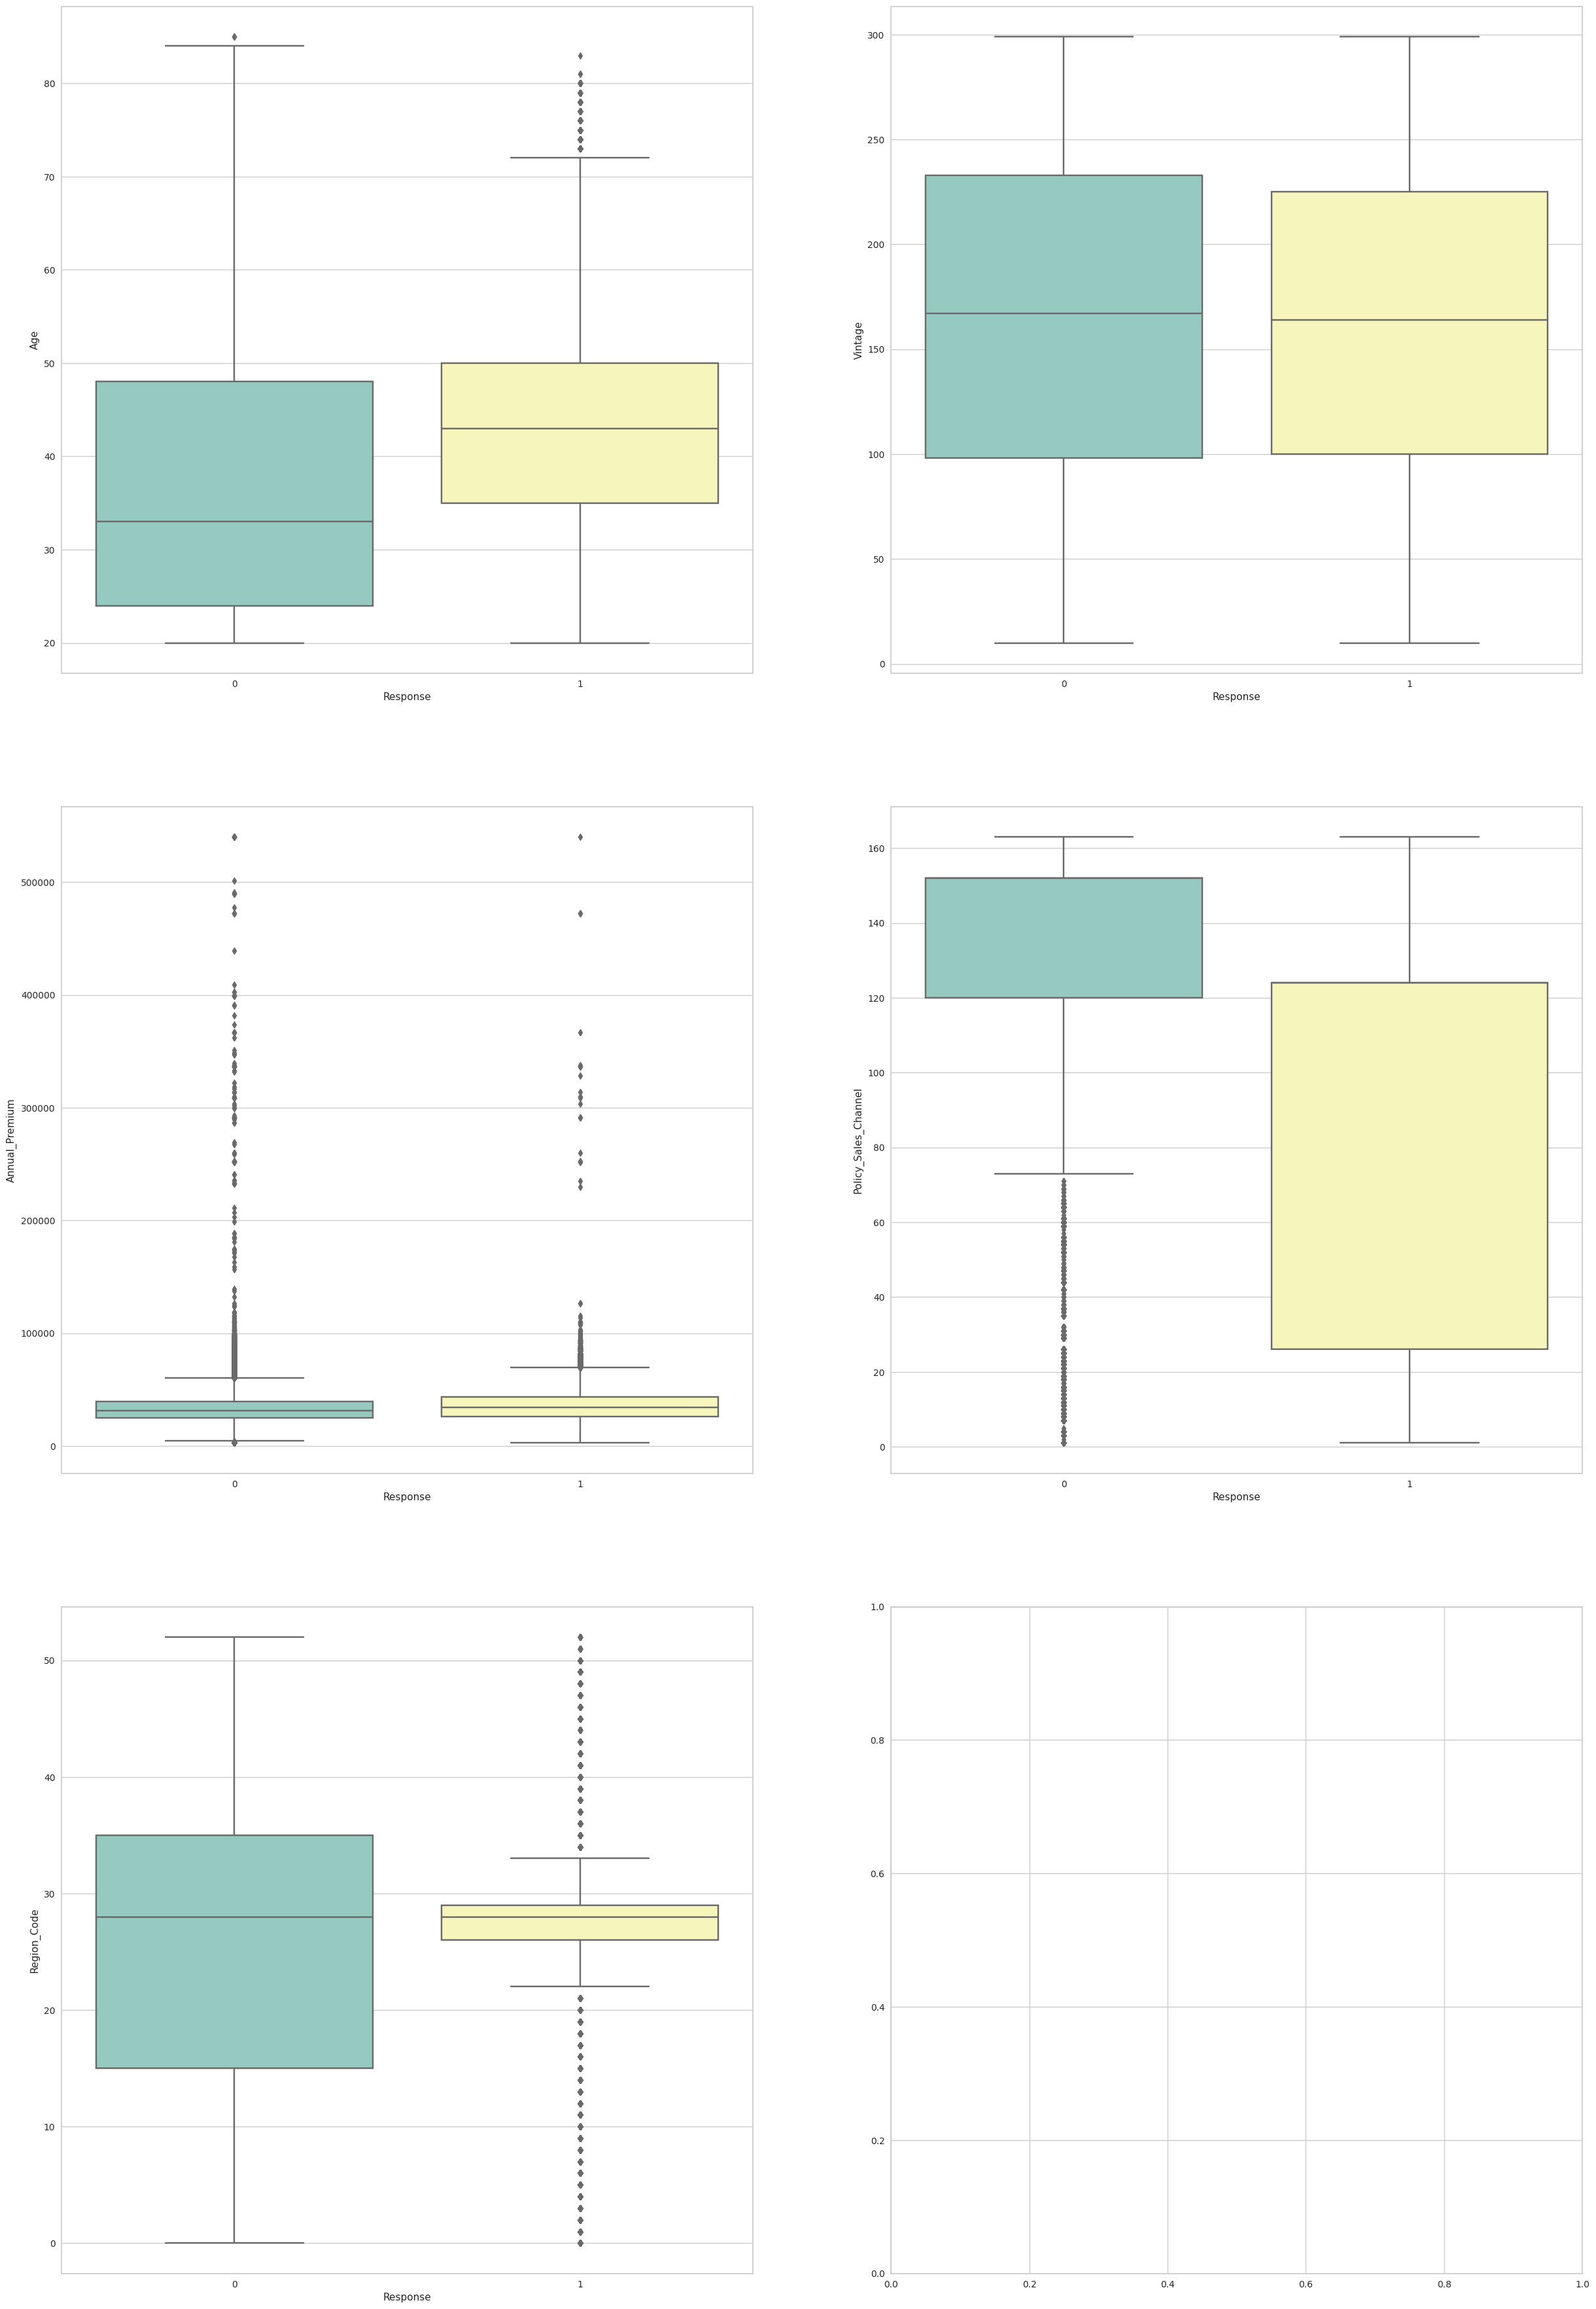

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(30, 45))
for var, subplot in zip(eda_continuous_features, ax.flatten()):
    sns.boxplot(x='Response', y=var, data=eda_verification_df, ax=subplot, palette='Set3')

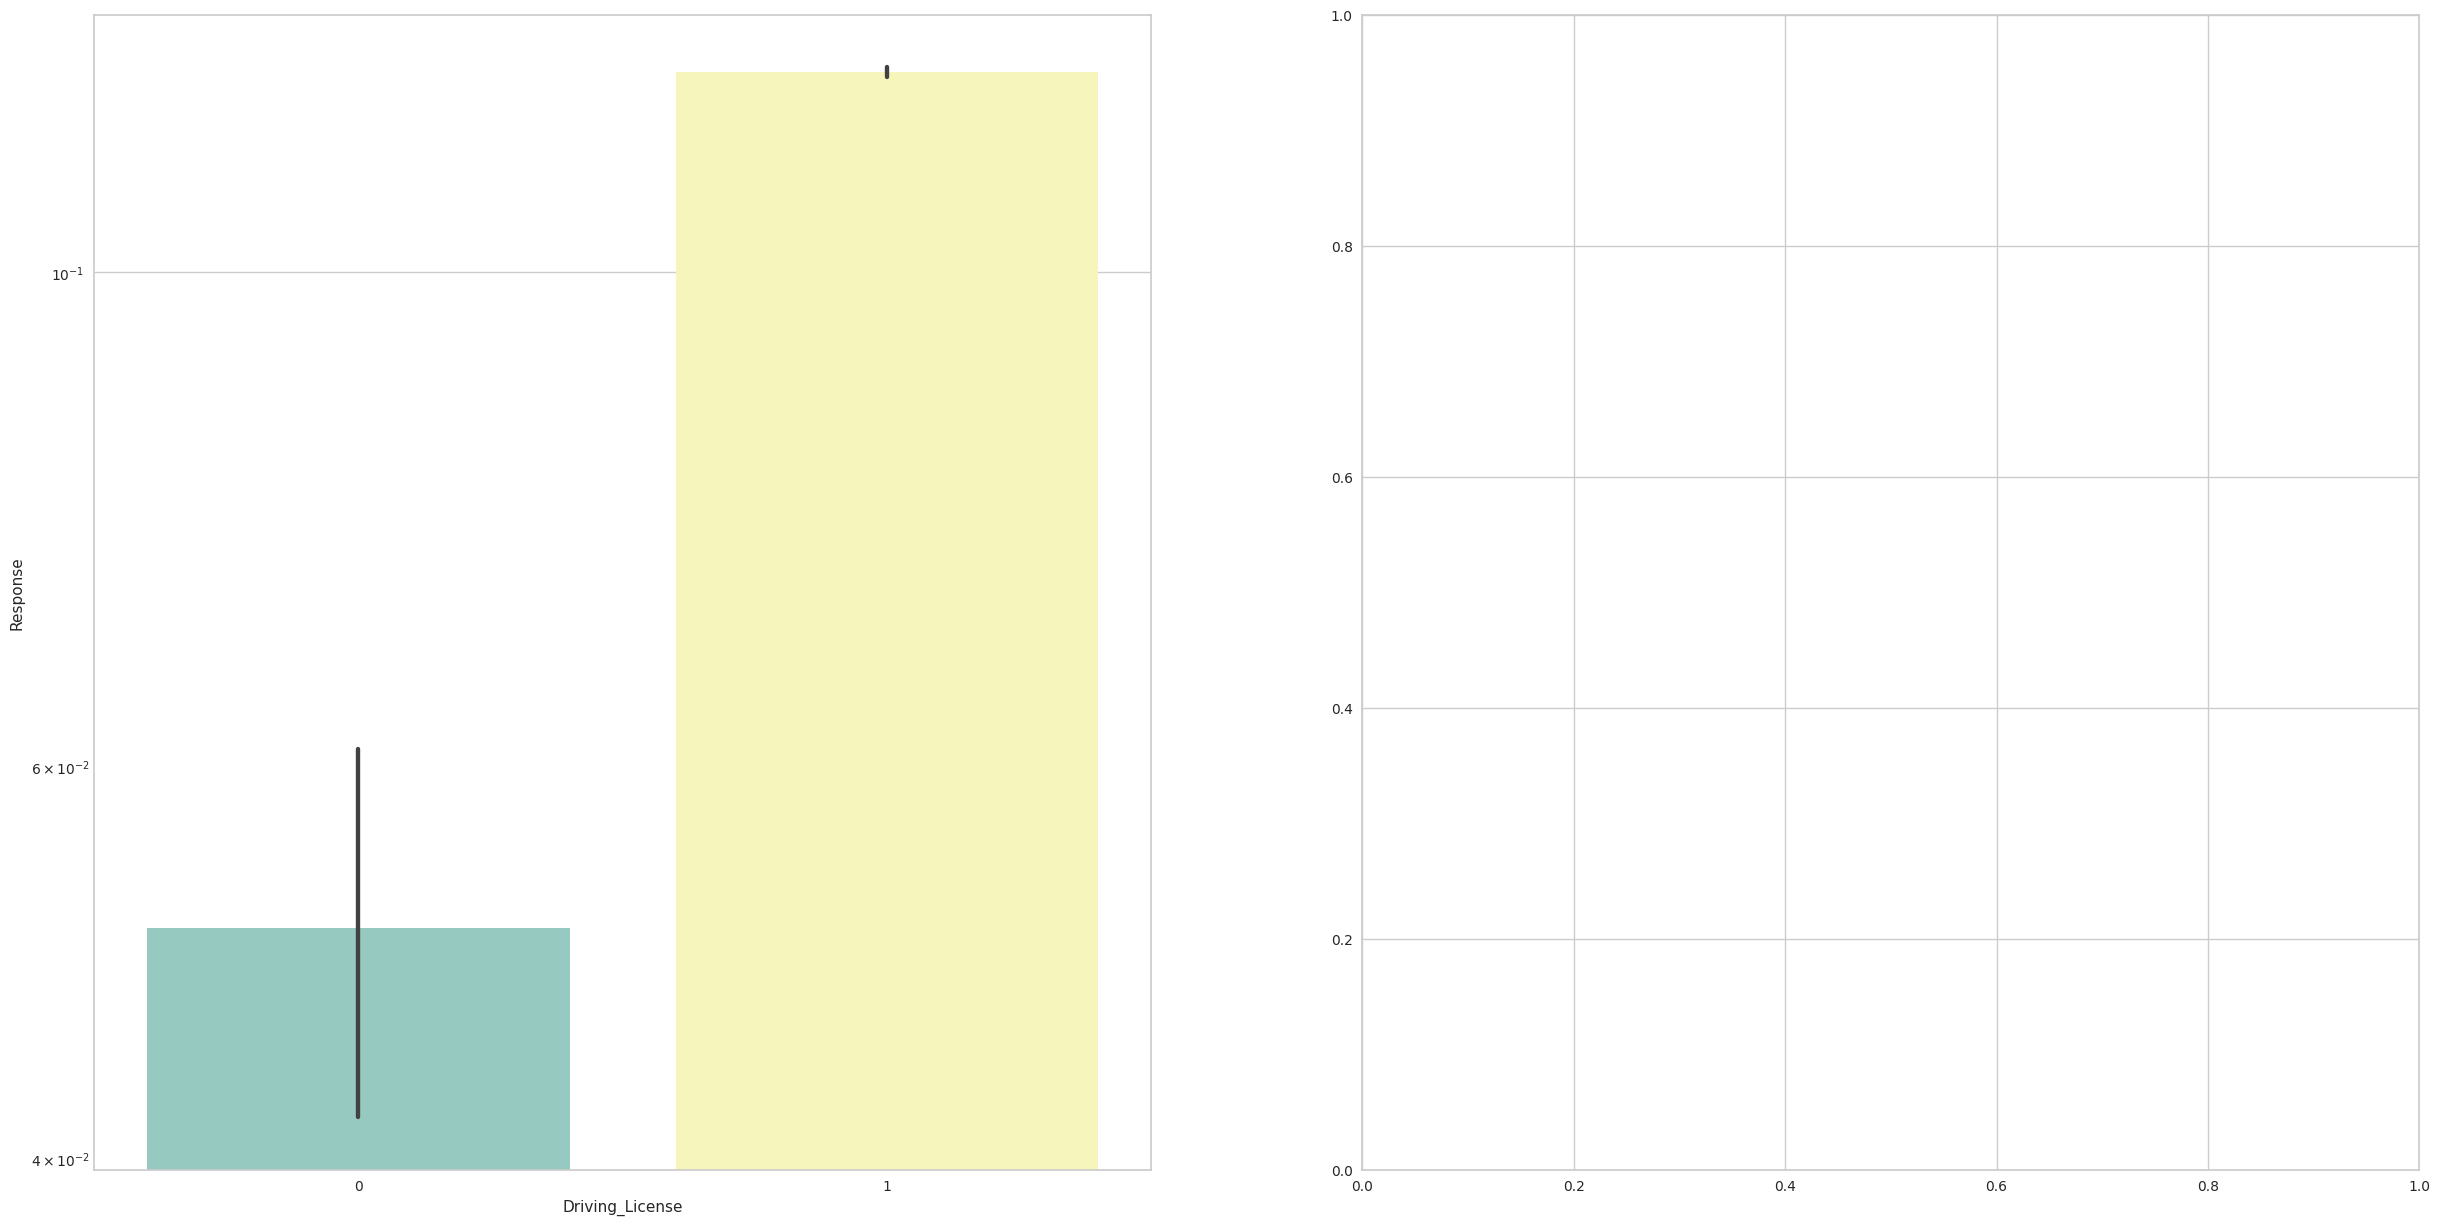

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
for var, subplot in zip(eda_original_binary_features, ax.flatten()):
    g = sns.barplot(x=var, y='Response', data=eda_verification_df, ax=subplot, palette='Set3')
    g.set_yscale("log")

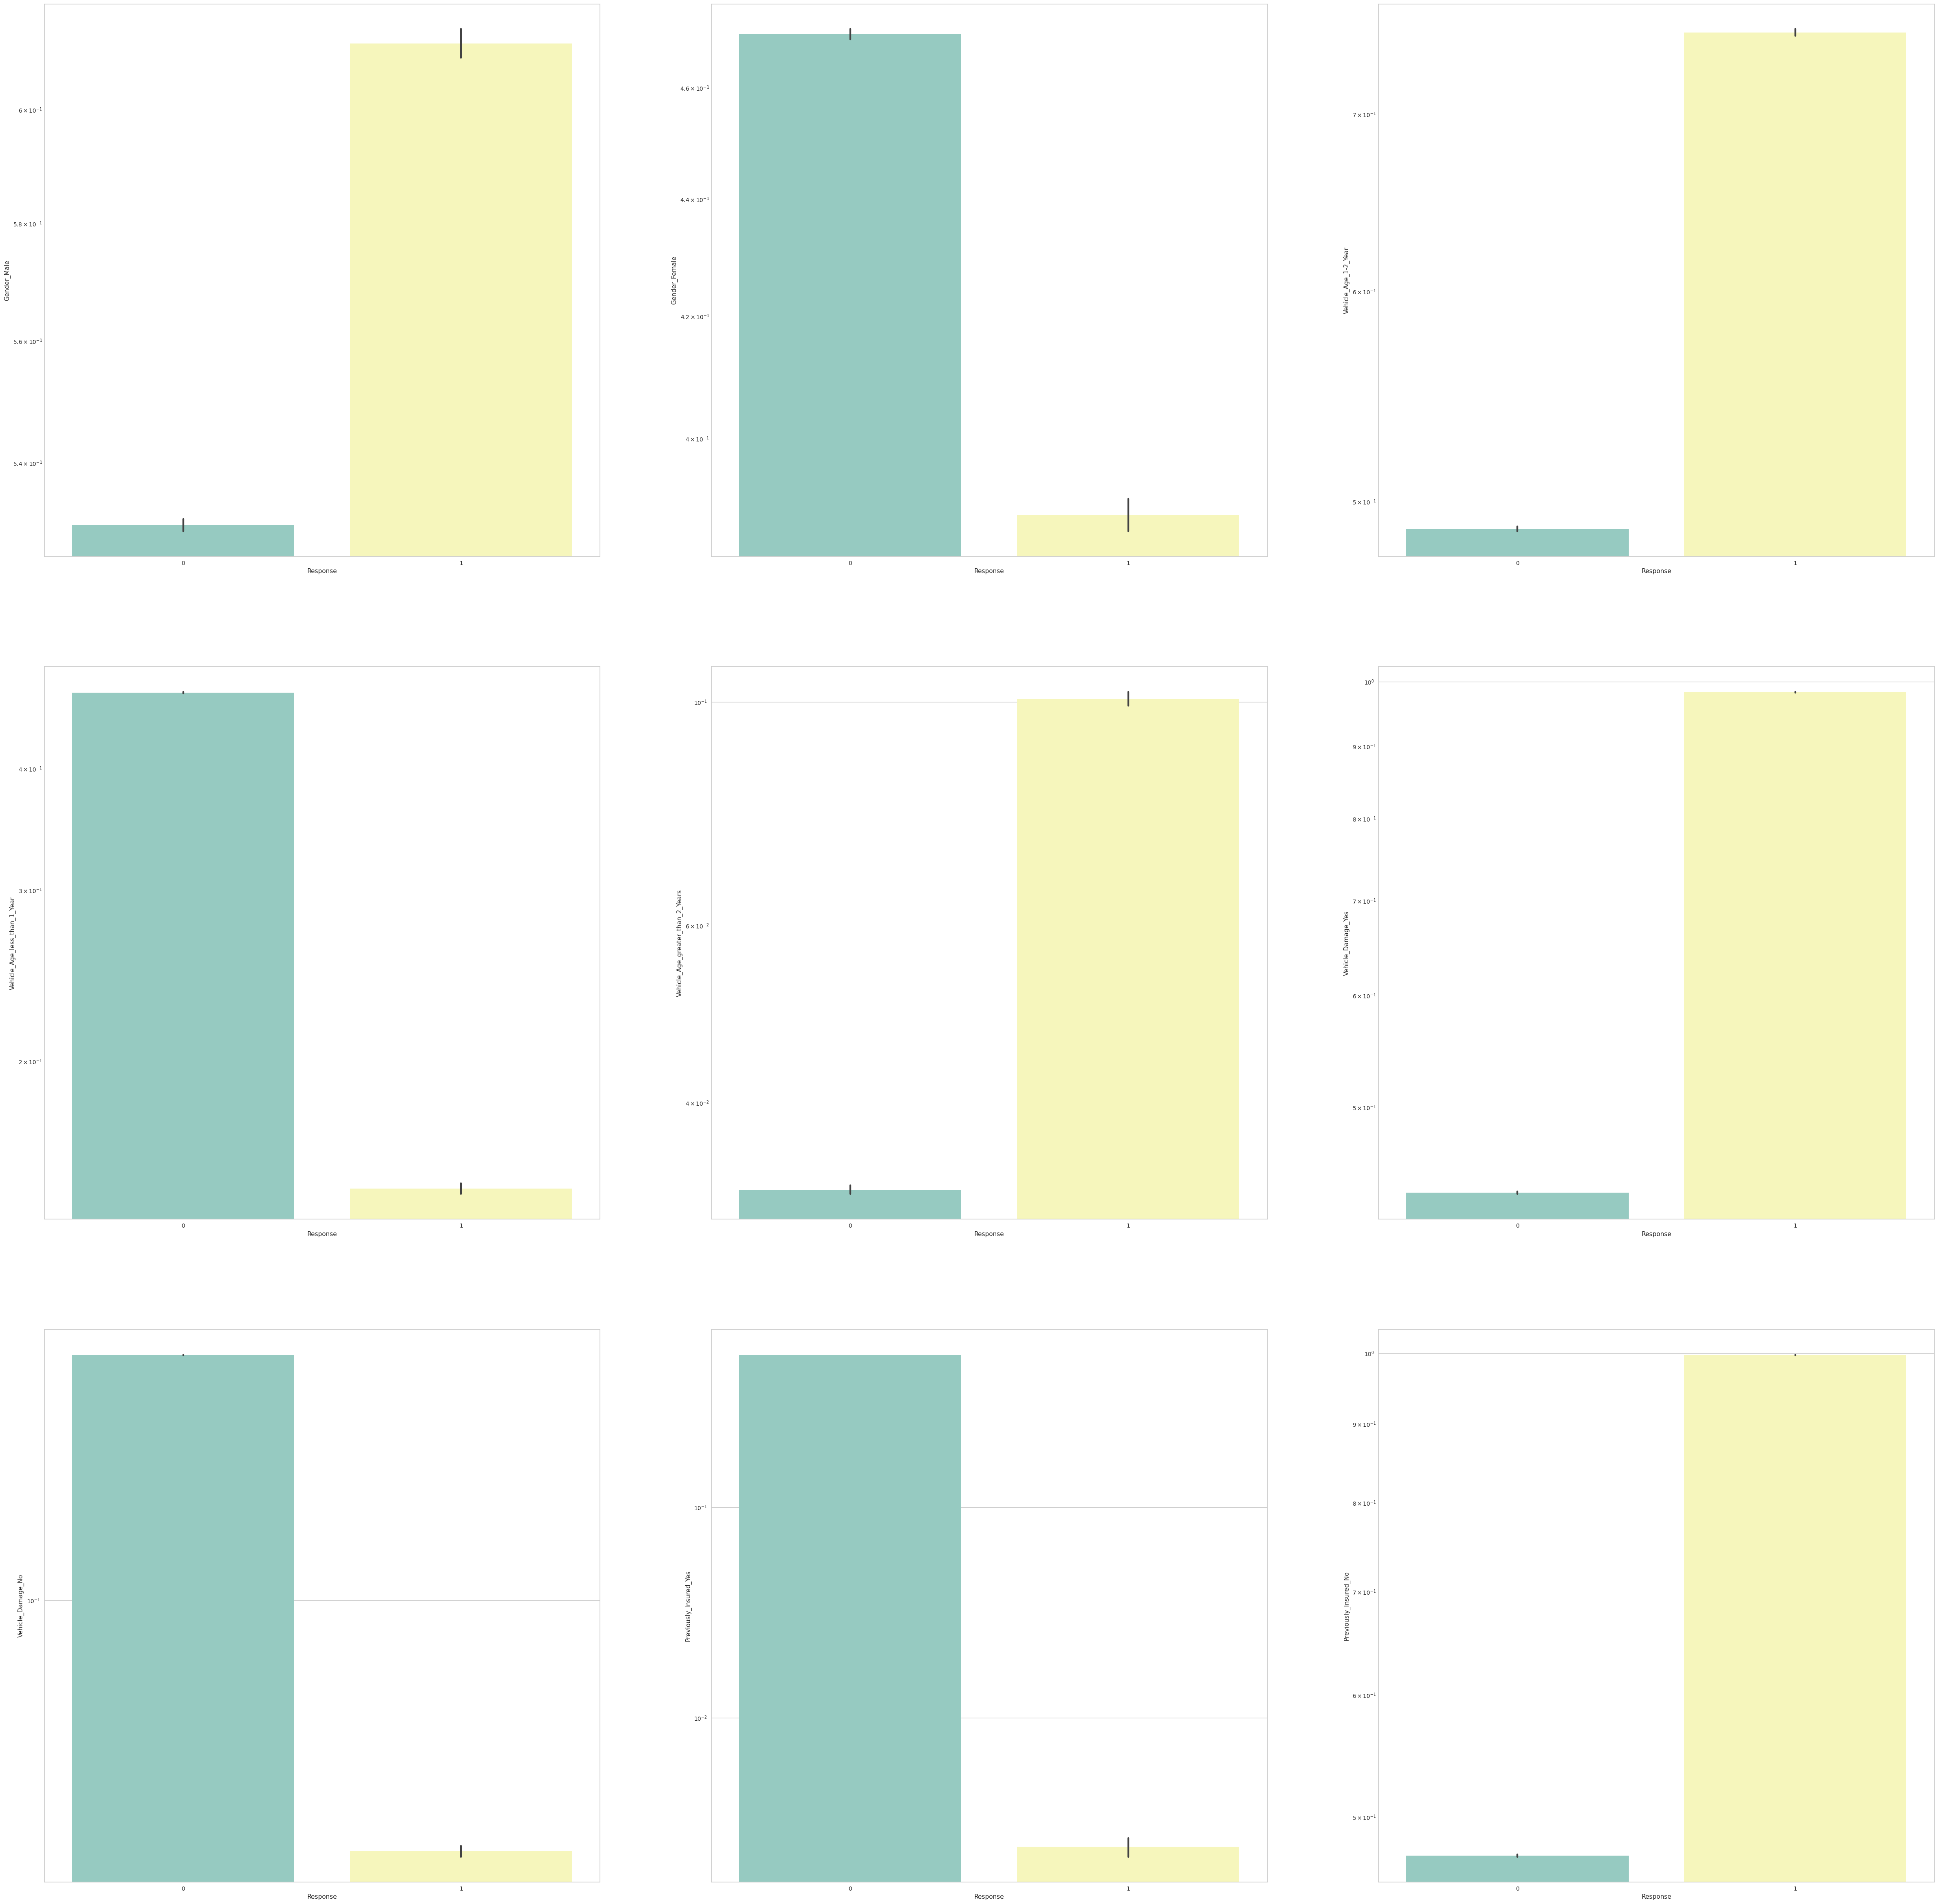

In [34]:
fig, ax = plt.subplots(3, 3, figsize=(60, 60))
for var, subplot in zip(eda_binary_features, ax.flatten()):
    g = sns.barplot(x='Response', y=var, data=eda_verification_df, ax=subplot, palette='Set3')
    g.set_yscale("log")

### Feature engineering

In [35]:
# determine the mutual information for numerical features

mutual_df = eda_verification_df[eda_continuous_features]
y_sampled = eda_verification_df.Response
mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"])
mutual_info

,Numerical_Feature_MI
Policy_Sales_Channel,0.099675
Region_Code,0.038229
Age,0.037820
Annual_Premium,0.033628
Vintage,0.014708


In [36]:
mutual_df_binary = eda_verification_df[eda_binary_features + eda_original_binary_features]
#binary features must be encoded to get mutual information
for colname in mutual_df_binary:
    mutual_df_binary[colname], _ = mutual_df_binary[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_binary, y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_binary.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Binary_Feature_MI"])
mutual_info

,Numerical_Feature_MI
Previously_Insured_No,0.174413
Previously_Insured_Yes,0.173984
Vehicle_Damage_Yes,0.166969
Vehicle_Damage_No,0.166043
Vehicle_Age_less_than_1_Year,0.115288
Vehicle_Age_1-2_Year,0.114594
Gender_Female,0.089597
Gender_Male,0.088850
Vehicle_Age_greater_than_2_Years,0.006671
Driving_License,0.000000


### Modeling and hyperparameter tuning

In [37]:
y = eda_df.Response
eda_df = eda_df.drop("Response", axis=1)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(eda_df, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
%%time

#Parameters are comming from OPTUNA, but I tunned them with %1 percent of the data.

model = XGBClassifier(
    n_estimators=10000,
    eta=0.05,
    alpha = 0.2545607592482198,
    subsample = 0.8388163485383147, 
    colsample_bytree = 0.2732499701466825, 
    max_depth = 16,
    min_child_weight = 5,
    gamma = 0.0017688666476104672,
    eval_metric='auc',
    random_state=random_state,
    max_bin=262143, #a weird max_bin, for reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516265
    enable_categorical=True
)


# Train the model with early stopping
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=200,
    verbose=500
)

# Print the best iteration
print("Best iteration:", model.best_iteration)

# Use the underlying booster to predict on validation set using the best iteration
booster = model.get_booster()
y_pred_prob = booster.predict(xgb.DMatrix(X_val, enable_categorical=True), iteration_range=(0, model.best_iteration + 1))
auc = roc_auc_score(y_val, y_pred_prob)
print(f"Validation AUC: {auc:.5f}")

[0]	validation_0-auc:0.80170
[500]	validation_0-auc:0.88828
[1000]	validation_0-auc:0.89003
[1500]	validation_0-auc:0.89088
[1944]	validation_0-auc:0.89099
Best iteration: 1744
Validation AUC: 0.89100
CPU times: user 4h 4min 48s, sys: 1min 50s, total: 4h 6min 39s
Wall time: 1h 7min 56s


### Explainable ML & Feature importances

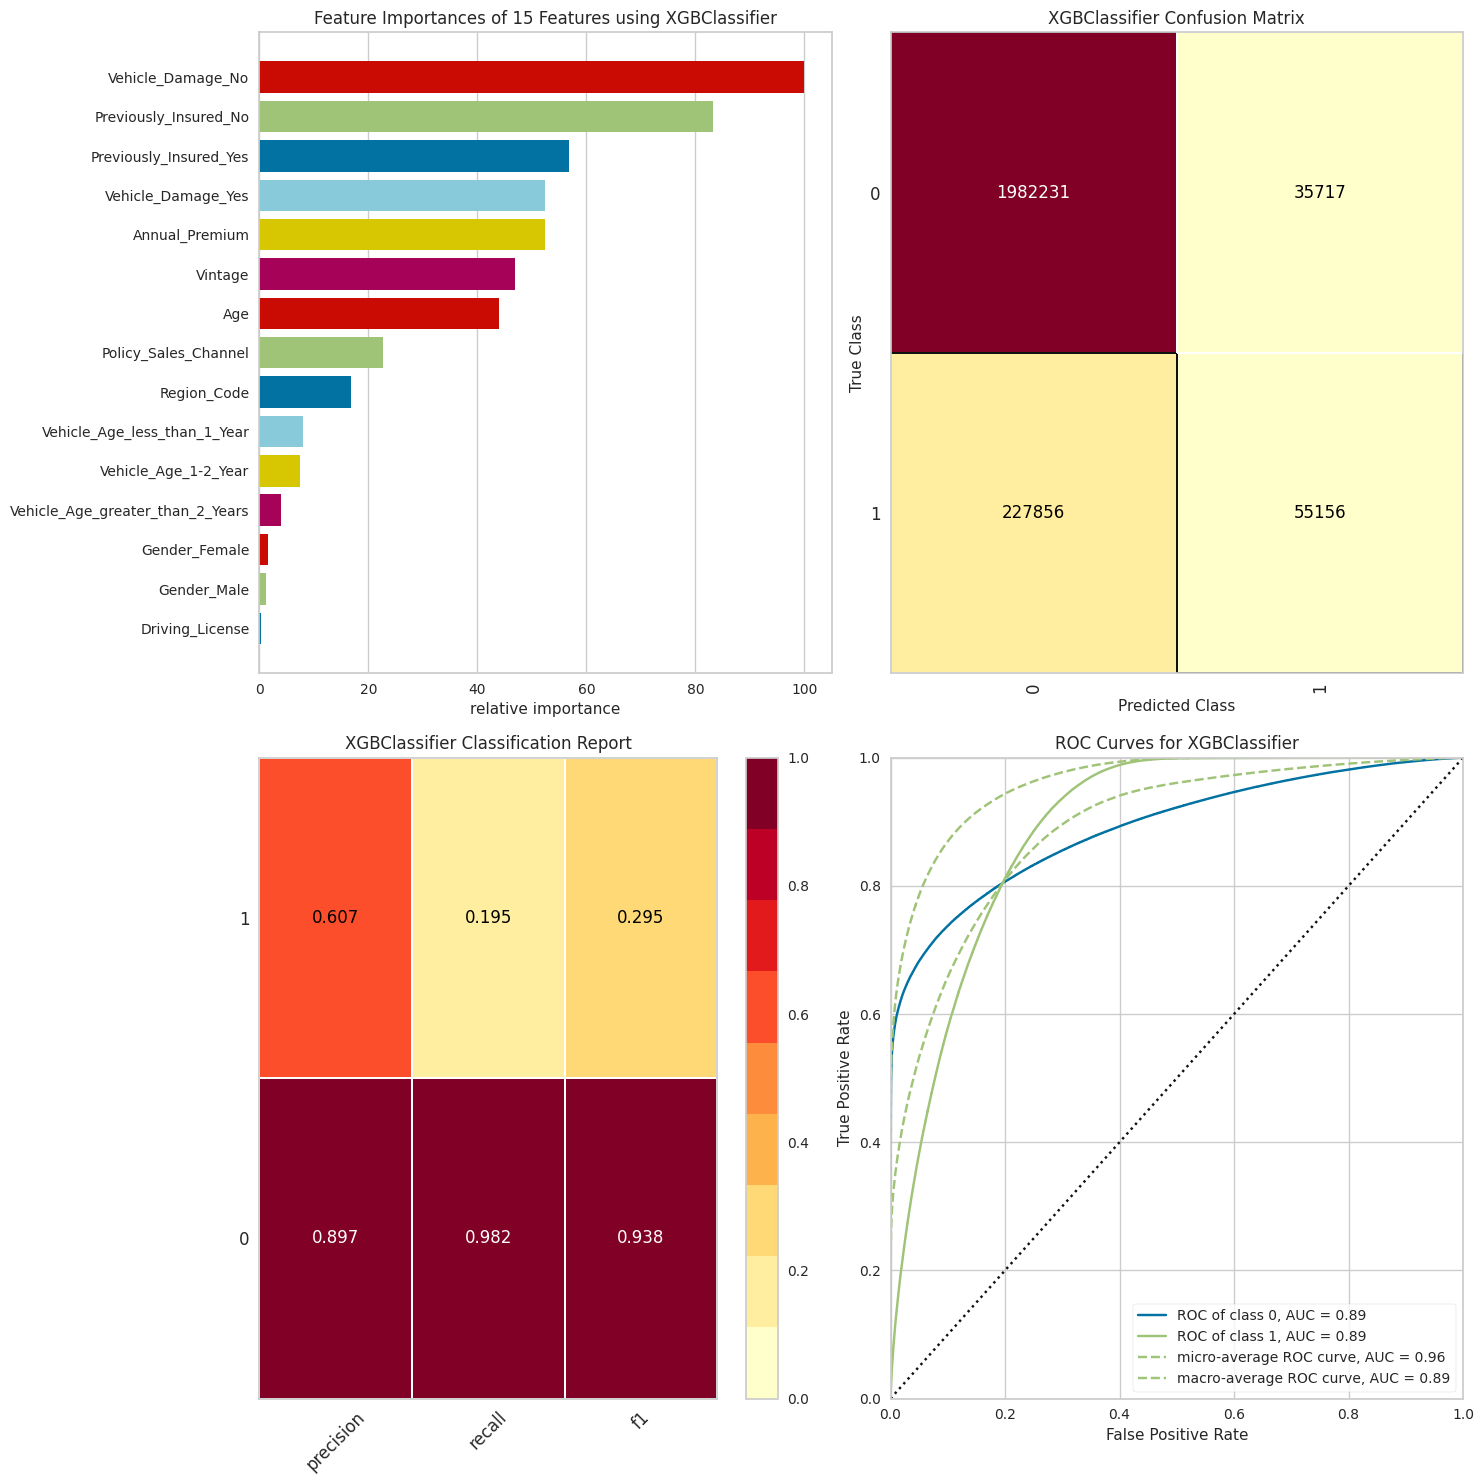

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

model = model
model.importance_type = 'total_gain'

visualgrid = [
    FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_val, y_val)
    viz.finalize()

plt.show()

### Shap is another tool for explainability.

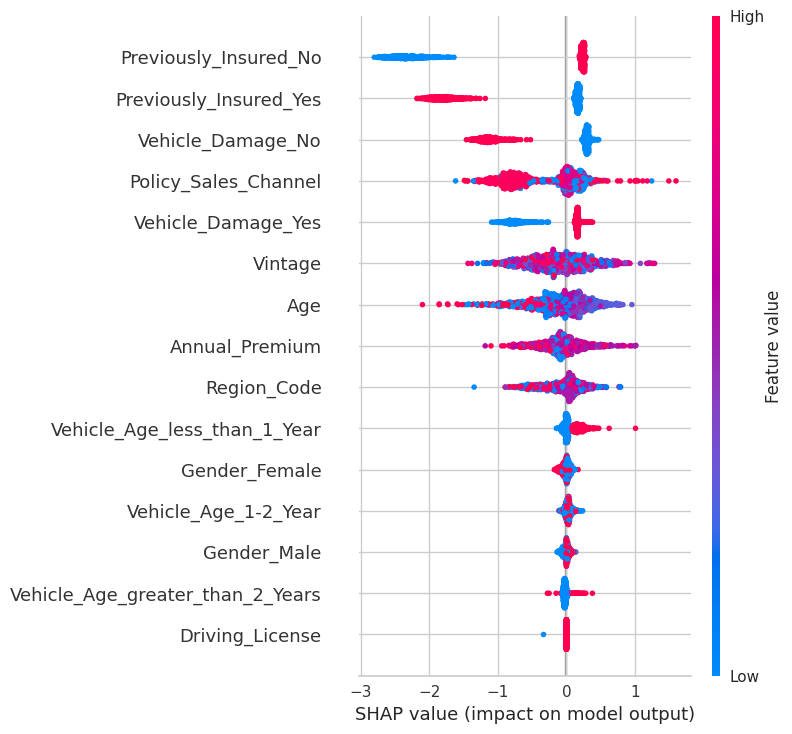

In [41]:
model = model

explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
#interventional argument breaks feature dependencies and provides better estimate

#It takes time just take some sample
test_explain = X_val.sample(n=1000, random_state=random_state)

shap_values = explainer.shap_values(test_explain, check_additivity=False )

# Summary plot of feature importance
shap.summary_plot(shap_values, test_explain, max_display = len(X_val) )

#### conclusion: Model importance score and SHAP agree on the most and least important features.

### Submission

In [42]:
eda_df.columns

Index(['Age', 'Driving_License', 'Region_Code', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Previously_Insured_No',
       'Previously_Insured_Yes', 'Vehicle_Age_1-2_Year',
       'Vehicle_Age_greater_than_2_Years', 'Vehicle_Age_less_than_1_Year',
       'Gender_Female', 'Gender_Male', 'Vehicle_Damage_No',
       'Vehicle_Damage_Yes'],
      dtype='object')

In [43]:
sub_df.columns

Index(['Age', 'Driving_License', 'Region_Code', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Previously_Insured_No',
       'Previously_Insured_Yes', 'Vehicle_Age_1-2_Year',
       'Vehicle_Age_greater_than_2_Years', 'Vehicle_Age_less_than_1_Year',
       'Gender_Female', 'Gender_Male', 'Vehicle_Damage_No',
       'Vehicle_Damage_Yes'],
      dtype='object')

In [44]:
column_names = eda_df.columns

sub_df = sub_df.reindex(columns=column_names)

In [45]:
booster = model.get_booster()
sub_preds = booster.predict(xgb.DMatrix(sub_df, enable_categorical=True), iteration_range=(0, model.best_iteration + 1))

In [46]:
output = pd.DataFrame({'id': sub_df.index,
                       'Response': sub_preds})

output.head()

,id,Response
0,11504798,0.002294
1,11504799,0.543548
2,11504800,0.241430
3,11504801,0.000090
4,11504802,0.073774


In [47]:
output.to_parquet('submission.parquet', index=False)

### Probability threshold

Optimal threshold: 0.1251174360513687
Maximum Youden Index: 0.6390457806382985


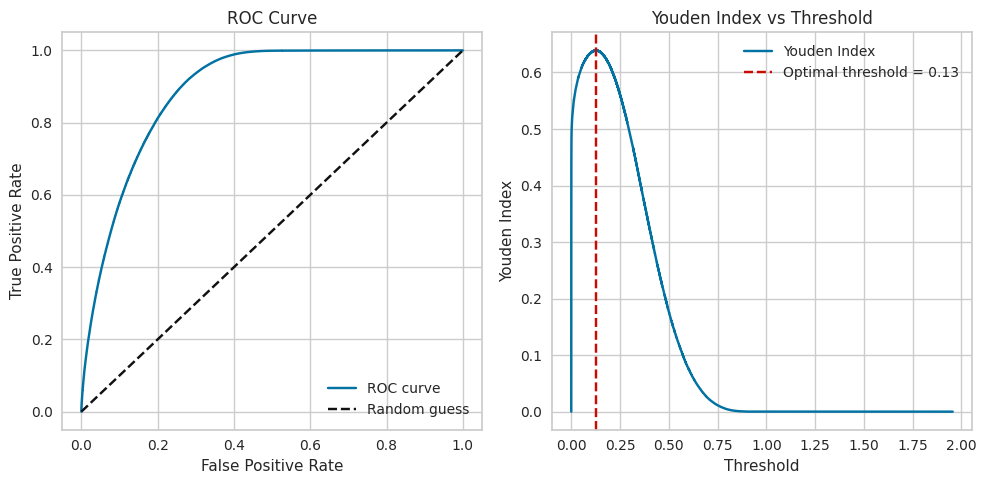

interactive(children=(FloatSlider(value=0.1251174360513687, description='threshold', max=1.0, step=0.01), Outp…

<function __main__.update_confusion_matrix(threshold)>

In [48]:
from ipywidgets import interact, FloatSlider


fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Calculate the Youden Index for each threshold
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
max_youden_index = np.max(youden_index)

print(f"Optimal threshold: {optimal_threshold}")
print(f"Maximum Youden Index: {max_youden_index}")

# Function to update the confusion matrix based on the selected threshold
def update_confusion_matrix(threshold):
    # Apply the threshold to get binary predictions
    final_preds = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_val, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix at threshold = {threshold:.2f}')
    plt.show()

# Plot ROC curve and Youden Index
plt.figure(figsize=(10, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Subplot 2: Youden Index
plt.subplot(1, 2, 2)
plt.plot(thresholds, youden_index, label='Youden Index')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Youden Index')
plt.title('Youden Index vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()

#Playing with slider bar 
interact(update_confusion_matrix, threshold=FloatSlider(value=optimal_threshold, min=0.0, max=1.0, step=0.01))